# Lab : Transfer Learning Using MobileNet (Cats and Dogs!)

### Overview
We will use a mobile net model and train it to recognize cats and dogs

### Run Platform
Run this on Google Colab

### References
- [MobileNet github](https://github.com/tensorflow/models/tree/master/research/slim/nets/mobilenet)
- [Transfer Learning using Mobilenet and Keras](https://towardsdatascience.com/transfer-learning-using-mobilenet-and-keras-c75daf7ff299)
- [Comparing MobileNet Models in TensorFlow](https://heartbeat.fritz.ai/exploring-the-mobilenet-models-in-tensorflow-d9d21774cdab)

## Before you start!
Set the hardware accelerator to None (to use CPU)

In [1]:
%%shell

# 1. Get Data
data_file='https://elephantscale-public.s3.amazonaws.com/data/images/cat-dog-redux.zip'
cat_dog_zip="cat-dog-redux-data.zip"
if [ ! -f "$cat_dog_zip" ] ; then
      echo "downloading $data_file"
	    wget -O $cat_dog_zip   $data_file
else
        echo "$cat_dog_zip exists"
fi



# 2 - extract
cat_dog_dir="cat-dog"

if [ ! -d "$cat_dog_dir" ] ; then
        echo "unzipping $cat_dog_zip"
        mkdir -p "$cat_dog_dir"
        (cd $cat_dog_dir; unzip -q "../$cat_dog_zip")
else
  echo "$cat_dog_dir exists"
fi

#  Mac : Cmd + /
# windows : Ctrl + /


cat-dog-redux-data.zip exists
cat-dog exists


In [2]:
# !unzip cat-dog-redux-data.zip

In [3]:
# ! wget -q https://s3.amazonaws.com/elephantscale-public/data/cat-dog/redux/cat-dog-redux-data.zip
# ! mkdir -p cat-dog
# ! cd cat-dog;  unzip -q ../cat-dog-redux-data.zip 

In [4]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications.mobilenet import MobileNet
import math

In [5]:
TRAIN_DATA_DIR = 'cat-dog-redux/train/'
VALIDATION_DATA_DIR = 'cat-dog-redux/val/'
TRAIN_SAMPLES = 500
VALIDATION_SAMPLES = 500
NUM_CLASSES=2
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE=64

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_datagen.flow_from_directory(
                        TRAIN_DATA_DIR,
                        target_size=(IMG_WIDTH, IMG_HEIGHT),
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        seed=12345,
                        class_mode='categorical')
validation_generator = val_datagen.flow_from_directory(
                        VALIDATION_DATA_DIR,
                        target_size=(IMG_WIDTH, IMG_HEIGHT),
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        class_mode='categorical')


Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [8]:
def model_maker():
    base_model = MobileNet(include_top=False, input_shape = (IMG_WIDTH,IMG_HEIGHT,3))
    for layer in base_model.layers[:]:
        layer.trainable = False # Freeze the layers
    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    return Model(inputs=input, outputs=predictions)

In [9]:
model = model_maker()
model.compile(loss='categorical_crossentropy',
              optimizer= keras.optimizers.Adam(lr=0.001),
              metrics=['acc'])
model.fit_generator(train_generator,
                    steps_per_epoch = math.ceil(float(TRAIN_SAMPLES) / BATCH_SIZE),
                    epochs=10,
                    validation_data = validation_generator,
                    validation_steps = math.ceil(float(VALIDATION_SAMPLES) / BATCH_SIZE))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
8/8 [==============================] - 7s 936ms/step - loss: 0.6199 - acc: 0.7620 - val_loss: 0.1885 - val_acc: 0.9360
Epoch 2/10
8/8 [==============================] - 7s 904ms/step - loss: 0.1998 - acc: 0.9180 - val_loss: 0.1000 - val_acc: 0.9700
Epoch 3/10
8/8 [==============================] - 7s 915ms/step - loss: 0.1645 - acc: 0.9380 - val_loss: 0.1067 - val_acc: 0.9580
Epoch 4/10
8/8 [==============================] - 7s 929ms/step - loss: 0.1426 - acc: 0.9400 - val_loss: 0.0715 - val_acc: 0.9740
Epoch 5/10
8/8 [==============================] - 7s 922ms/step - loss: 0.0858 - acc: 0.9740 - val_loss: 0.0791 - val_acc: 0.9660
Epoch 6/10
8/8 [==============================] - 7s 915ms/step - loss: 0.0809 - acc: 0.9740 - val_loss: 0.0604 - val_acc: 0.9760
Epoch 7/10
8/8 [==============================] - 7s 913ms/step - loss: 0.0551 - acc: 0.9840 - val_loss: 0.0694 - val_acc: 0.9680
Epoch 8/10
8/8

In [10]:
model.save('model.h5')

In [11]:
from keras.models import load_model
model = load_model('model.h5')

In [12]:
import numpy as np

img_path = 'cat-dog-redux/val/dog/dog.3045.jpg'
img = keras.preprocessing.image.load_img(img_path, target_size=(224,224))
img_array = keras.preprocessing.image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = expanded_img_array / 255. # Preprocess the image
prediction = model.predict(preprocessed_img)
print(prediction)
print(validation_generator.class_indices)
[[0.9967706]]
{'dog': 1, 'cat': 0}

[[0.0217451  0.97825485]]
{'cat': 0, 'dog': 1}


{'cat': 0, 'dog': 1}

In [13]:
#####################
##### VARIABLES #####
#####################

IMG_WIDTH, IMG_HEIGHT = 224, 224
VALIDATION_DATA_DIR = 'cat-dog-redux/val/'
VALIDATION_BATCH_SIZE = 64

#####################
## DATA GENERATORS ##
#####################

validation_datagen = ImageDataGenerator(
        rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
        VALIDATION_DATA_DIR,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=VALIDATION_BATCH_SIZE,
        shuffle=False,
        class_mode='categorical')

ground_truth = validation_generator.classes

Found 500 images belonging to 2 classes.


In [14]:
predictions = model.predict_generator(validation_generator, steps=(500/VALIDATION_BATCH_SIZE))


Instructions for updating:
Please use Model.predict, which supports generators.


In [15]:
# prediction_table is a dict with index, prediction, ground truth
prediction_table = {}
for index, val in enumerate(predictions):
    #get argmax index
    index_of_highest_probability = np.argmax(val)
    value_of_highest_probability = val[index_of_highest_probability]
    prediction_table[index] = [value_of_highest_probability, index_of_highest_probability,
    ground_truth[index]]
assert len(predictions) == len(ground_truth) == len(prediction_table)

In [16]:
# Helper function that finds images that are closest
# Input parameters:
#   prediction_table: dictionary from the image index to the prediction
#                      and ground truth for that image
#   get_highest_probability: boolean flag to indicate if the results
#                            need to be highest (True) or lowest (False) probabilities
#   label: id of category
#   number_of_items: num of results to return
#   only_false_predictions: boolean flag to indicate if results
#                           should only contain incorrect predictions
def get_images_with_sorted_probabilities(prediction_table, get_highest_probability,
 label, number_of_items, only_false_predictions=False):
    sorted_prediction_table = [ (k, prediction_table[k]) for k in sorted(prediction_table, key=prediction_table.get, reverse= get_highest_probability)]
    result = []
    for index, key in enumerate(sorted_prediction_table):
        image_index, [probability, predicted_index, gt] = key
        
        if predicted_index == label:
            if only_false_predictions == True:
                if predicted_index != gt:
                    result.append([image_index, [probability, predicted_index, gt] ])
            else:
                result.append([image_index, [probability, predicted_index, gt] ])
        if len(result) >= number_of_items:
            return result

In [17]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Helper functions to plot the nearest images given a query image
def plot_images(filenames, distances, message):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20,15))
    columns = 5
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        ax.set_title( "\n\n"+  filenames[i].split("/")[-1]+"\n"+"\nProbability: " +
        str(float("{0:.2f}".format(distances[i]))))
        plt.suptitle( message, fontsize=20, fontweight='bold')
        plt.axis('off')
        plt.imshow(image)


def display(sorted_indicies, message, fnames):
    similar_image_paths = []
    distances = []
    for name, value in sorted_indicies:
        [probability, predicted_index, gt] = value
        similar_image_paths.append(VALIDATION_DATA_DIR + fnames[name])
        distances.append(probability)
    plot_images(similar_image_paths,distances, message)

Which images are we most confident contain dogs? Let’s find images with the highest prediction probability (i.e. closest to 1.0) with the predicted class dog (i.e. 1).



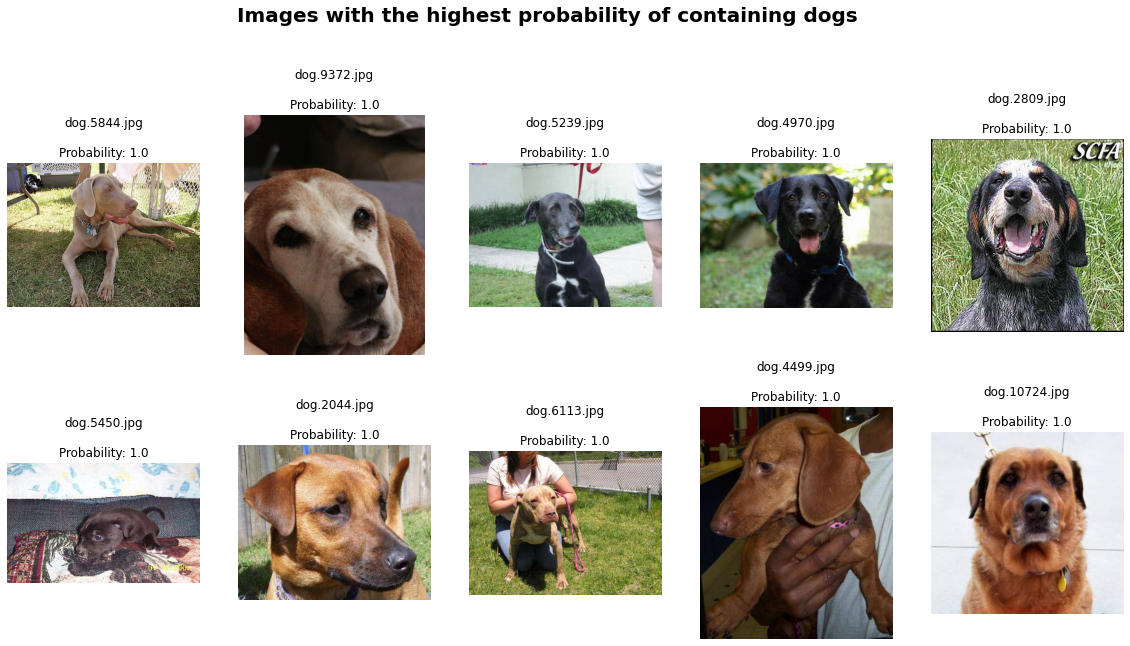

In [18]:
# Most confident predictions of 'dog'
indices = get_images_with_sorted_probabilities(prediction_table, True, 1, 10, False)
message = 'Images with the highest probability of containing dogs'
display(indices[:10], message, validation_generator.filenames)

These images are indeed very dog-like. One of the reasons why the probability is so high can be attributed to containing multiple dogs, as well as clear, unambiguous views. Now let’s try to find which images are we least confident of containing dogs?

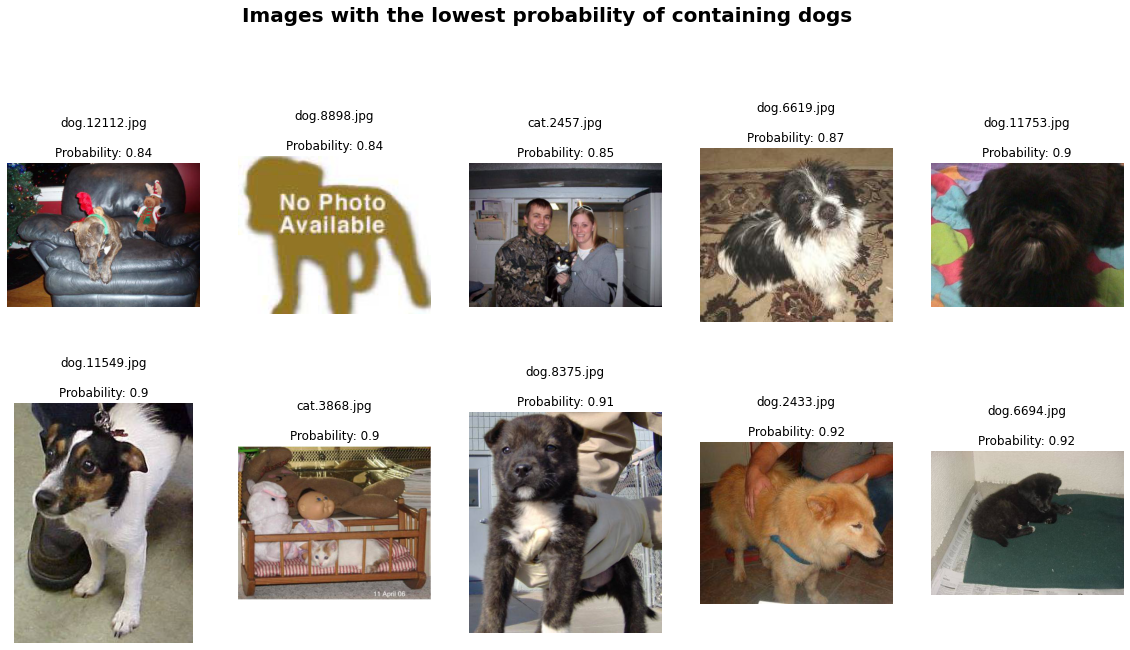

In [19]:
# Least confident predictions of 'dog'
indices = get_images_with_sorted_probabilities(prediction_table, False, 1, 10, False)
message = 'Images with the lowest probability of containing dogs'
display(indices[:10], message, validation_generator.filenames)


To repeat, these are the images our classifier is most unsure of containing a dog. Most of these predictions are right at the tipping point (i.e. 0.5 probability) to be the majority prediction. Keep in mind the probability of being a cat is just slightly smaller, around 0.49. Compared to the previous set of images, these images are often smaller and less clear images. And often contain mispredictions - only 2 of the 10 images were the correctly predicted. One possible way to do better here is training with a larger set of images.

If you are concerned about these misclassifications, worry not. A simple trick to improve the classification accuracy is to have a higher threshold for accepting a classifier’s results, say 0.75. If the classifier is unsure of an image category, its results are withheld. In chapter 4, we will look at how to find an optimal threshold.

Talking of mispredictions, they are obviously expected when the classifier has low confidence (i.e. near 0.5 probability for a 2 class problem). But what we don’t want is to mispredict when our classifier is really sure of its predictions. Let’s check which images the classifier is confident contain dogs in spite of them being cats.

In [20]:
# This may not work if there are not enough mispredictions

get_images_with_sorted_probabilities(prediction_table,True,1,10,True)



In [21]:
# Incorrect predictions of 'dog'
indices = get_images_with_sorted_probabilities(prediction_table, True, 1, 10, True)
message = 'Images of cats with the highest probability of containing dogs'

if indices:
  display(indices[:10], message, validation_generator.filenames)
else:
  print("Not enough images fit into this category")

Not enough images fit into this category


Hmm… turns out half of these images contain both cats and dogs, and our classifier is correctly predicting the dog category as they are bigger in size in these images. Thus it’s not the classifier but the data which is incorrect here. This often happens in large datasets. The remaining half often contain unclear and relatively smaller objects (but ideally we want to expect lower confidence for these hard to identify images).

Repeating the same set of question for the cat class, which images are more cat-like?

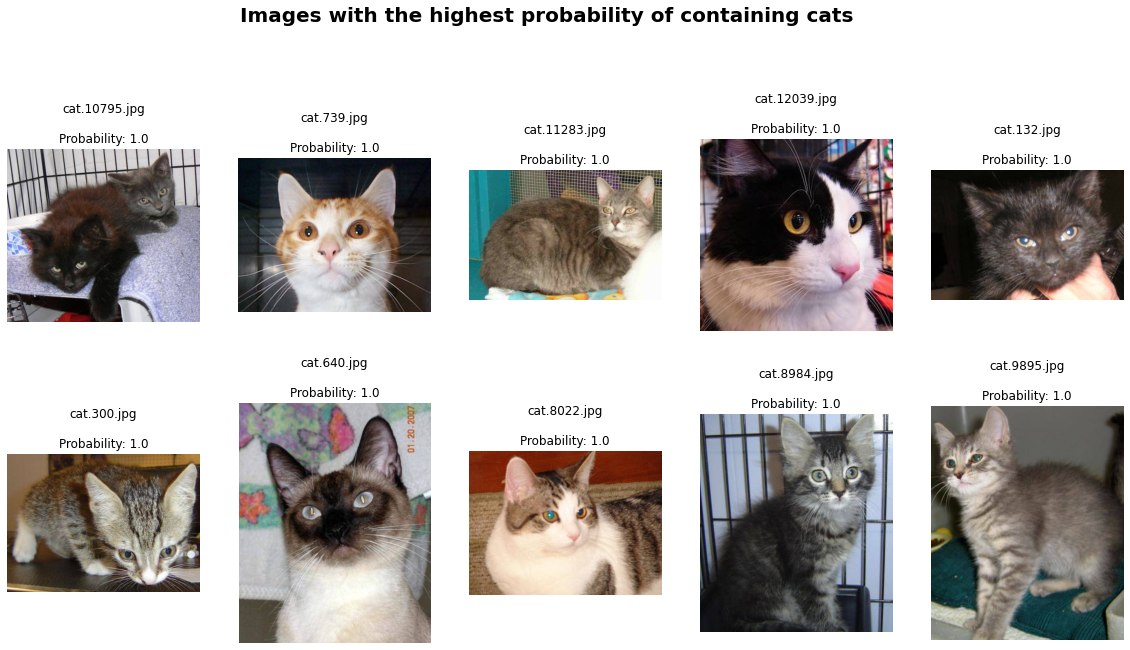

In [22]:
# Most confident predictions of 'cat'
indices = get_images_with_sorted_probabilities(prediction_table, True, 0, 10, False)
message = 'Images with the highest probability of containing cats'
display(indices[:10], message, validation_generator.filenames)

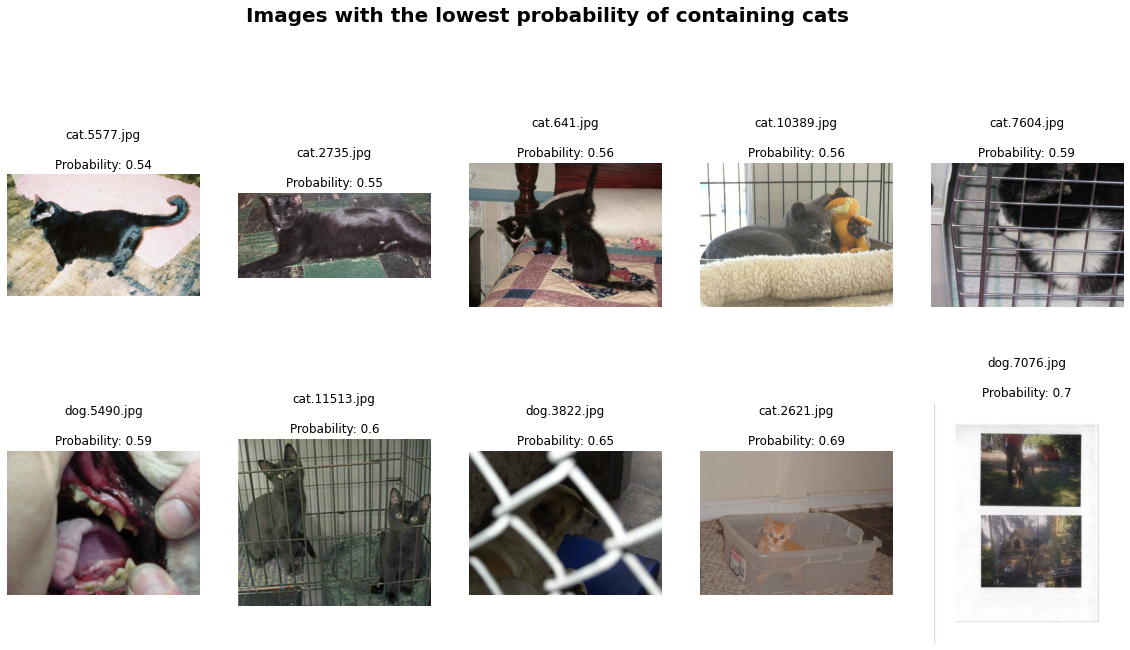

In [23]:
# Least confident predictions of 'cat'
indices = get_images_with_sorted_probabilities(prediction_table, False, 0, 10, False)
message = 'Images with the lowest probability of containing cats'
display(indices[:10], message, validation_generator.filenames)

Like previously seen, the key object size is small, and some of the images are quite unclear meaning there is too much contrast in some cases or the object is too bright, something not in line with most of the training images. For example, the camera flash in the eighth (dog.6680) and tenth (dog.1625) images makes it hard to recognize. The sixth image contains a dog in front of a sofa of the same color. Two images contain cages.

Lastly, which images is our classifier mistakenly sure of containing cats?

In [24]:
# Incorrect predictions of 'cat'
indices = get_images_with_sorted_probabilities(prediction_table, True, 0, 10, True)

if indices:
  message = 'Images of dogs with the highest probability of containing cats'
  display(indices[:10], message, validation_generator.filenames)
else:
  print ("no incorrect predictions of cat")


no incorrect predictions of cat
